<a href="https://colab.research.google.com/github/mlerma54/RSIGradCAM/blob/main/RSI_Grad_CAM_w_autobaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSI-Grad-CAM (Rieman-Stieltjes Integrated Grad-CAM)**<br>
# **With automatic computation of baseline**

In [1]:
ver='2022-04-06a'
print(ver)

2022-04-06a


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
MyDrive


In [3]:
# this is to time execution time
!pip install ipython-autotime
%load_ext autotime

time: 171 µs (started: 2022-04-06 18:59:55 +00:00)


In [4]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

2.8.0
time: 2.51 s (started: 2022-04-06 18:59:55 +00:00)


## <font color="red">Please give below paths as per the paths in your system</font>

In [5]:
root = '/content/gdrive/My Drive/RSI-Grad-CAM/'
images_dir = root + 'images/'

time: 1.59 ms (started: 2022-04-06 18:59:58 +00:00)


In [6]:
import os

for d in [root, images_dir]:
  assert(os.path.isdir(d))

time: 2.09 ms (started: 2022-04-06 18:59:58 +00:00)


- Libraries

In [7]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import imutils
import cv2

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

time: 25.2 ms (started: 2022-04-06 18:59:58 +00:00)


# **RSI-Grad-CAM**

In [8]:
# RSI-GradCAM Class

class RSI_GradCAM:

  def __init__(self, model, classIdx=None, layerName=None, baseline=None, m_steps=50, batch_size=32, add_softmax=False):
    '''
    - INPUT parameters
    model: CNN to which we wish to apply this attribution method
    classIdx (optional): integer denoting the class for which we want to compute attributions 
                        - it can be entered here (and remain fixed after instantation), or as a parameter in compute_heatmap()
    layerName (optional): name of the convolutional layer where we are going to compute the heatmap, default: the last one
    baseline: baseline input
    m_steps (optional): interpolation steps
    batch_size: number of gradients to compute for each pass of the integrated gradients loop
    add_softmax: set True if the model lacks a final softmax
    '''

    # store input parameters
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    self.baseline = baseline # baseline image, it could be a completely black image
    self.m_steps = m_steps # number of interpolation steps
    self.batch_size = batch_size # number of gradients to compute for each pass of the integrated gradients loop
    self.add_softmax = add_softmax


    # if the layer name is None, attempt to automatically find the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()


    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the chosen layer
    # in the network, and (3) the output of the softmax activations from the model
    self.gradModel = tensorflow.keras.models.Model(inputs=[self.model.inputs],
                          outputs=[self.model.get_layer(self.layerName).output,
                                   self.model.output])
    
  def find_target_layer(self):
    '''
    Finds the final convolutional layer in the network
    by looping over the layers of the network in reverse order
    '''

    for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name

    # otherwise, we could not find a 4D layer so the
    # algorithm cannot be applied
    raise ValueError("No 4D layer found. Cannot apply {}.".format(type(self).__name__))

  def interpolate_images(self, baseline, image, alphas):
    '''
    Returns an array of images interpolated between baseline and final image
    '''

    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

  def stieljes_integral_approximation(self, gradients, convOutputs):
    '''
    Riemann-Stieltjes Integral approximation,
    arguments are integrand and integrator respectively
    '''

    # riemann_trapezoidal (average height of trapezoid)
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    # integrator increments (lenght of trapezoid base)
    incr_convOutputs = convOutputs[1:] - convOutputs[:-1]
    # terms in the Riemann-Stieltjes Integral approximation
    summands = grads * incr_convOutputs
    # add them up
    integrated_gradients = tf.math.reduce_sum(summands, axis=0)
    return integrated_gradients  


  def compute_heatmap(self, image, classIdx=None, eps=1e-8):
    '''
    - INPUT parameters:
    image: the input image
    classIdx (optional): integer denoting the class about which we want to compute attributions
    eps: small term to avoid division by zero, adjust as needed

    - OUTPUT:
    cam: class activation map (raw heatmap without resizing or coloring)
    heatmap: cam after resizing to imput image size, and coloring
    '''

    if classIdx == None:
      classIdx=self.classIdx

    if classIdx == None:
      raise ValueError("No classIdx provided. Cannot compute heatmap.")


    im_shape = image.shape
    if len(im_shape) == 4 and im_shape[0] == 1:
      image_sqz = image[0] # remove single batch dimension
    elif len(im_shape) == 3:
      image_sqz = image
      image = np.expand_dims(image, axis=0)
    else:
      raise ValueError("Input image shape {} is invalid.".format(im_shape))

    if image_sqz.shape != self.baseline.shape:
      raise ValueError("Input and baseline images have different shapes: {} {}".format(image_sqz.shape,self.baseline.shape)) 
      

    # generate interpolating alphas between 0.0 and 1.0
    alphas = tf.linspace(start=0.0, stop=1.0, num=self.m_steps+1)

    # Initialize TensorArray outside loop to collect convolutional outputs and gradients.    
    convOutput_batches = tf.TensorArray(tf.float32, size=self.m_steps+1)
    gradient_batches = tf.TensorArray(tf.float32, size=self.m_steps+1)

    ############################# MAIN LOOP ####################################

    # Iterate alphas range and batch computation for speed, memory efficiency,
    # and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), self.batch_size):
      from_ = alpha
      to = tf.minimum(from_ + self.batch_size, len(alphas))
      alpha_batch = alphas[from_:to]

      # interpolated images (like in integrated gradients)
      image_batch =  self.interpolate_images(self.baseline, image_sqz, alpha_batch)

      # record operations for automatic differentiation
      with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # images through the gradient model, and grab the loss
        # associated with the specific class index
        input_batch = tf.cast(image_batch, tf.float32)
        (convOutput_batch, predictions) = self.gradModel(input_batch)
        if self.add_softmax: # add final softmax if model does not have it
          loss = tf.nn.softmax(predictions,axis=-1)[:, classIdx]
        else:
          loss = predictions[:, classIdx]

      # use automatic differentiation to compute the batch of gradients
      gradient_batch = tape.gradient(loss, convOutput_batch)

      # Write batch indices and gradients to extend TensorArray
      gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch) 
      convOutput_batches = convOutput_batches.scatter(tf.range(from_, to), convOutput_batch)

    ############################################################################
    # At the end of the loop stack batches together row-wise into single tensor
    convOutputs = convOutput_batches.stack()
    gradients = gradient_batches.stack()
    ############################################################################

    incr_convOutputs = convOutputs - convOutputs[0] # incremental convolutional from baseline
    total_incr_convOutputs = convOutputs[-1] - convOutputs[0] # total incremental convolutional 

    # we are interested only in positive values
    castIncr_convOutputs = tf.cast(total_incr_convOutputs > 0, "float32") 
    castConvOutputs = tf.cast(convOutputs[-1] > 0, "float32")

    ###############################################################################
    # compute guided gradients - several options, uncomment the one you want to use

    # Note: 'selected_units' is intended to select which units 
    # have a positive contribution to the class score.
    # Feel free to modify the code and experiment with
    # different ways to select the units.
    
    integrated_gradients = self.stieljes_integral_approximation(gradients,convOutputs)
    cast_integrated_gradients = tf.cast(integrated_gradients > 0, "float32")
    selected_units = castConvOutputs * cast_integrated_gradients * castIncr_convOutputs
    guidedIGrads = selected_units * integrated_gradients
    

    ############################################################################

    # compute the average of the (guided) gradient values, and using them as weights,
    # compute the ponderation of the filters with respect to the weights
    weights = tf.reduce_mean(guidedIGrads, axis=(0, 1))
    #weights = tf.reduce_mean(integrated_gradients, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs[-1]), axis=-1)
    #cam = tf.reduce_sum(tf.multiply(weights, total_incr_convOutputs), axis=-1)

    cam *= tf.cast(cam > 0, dtype=tf.float32) # apply final ReLU

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image dimensions
    (w, h) = (image.shape[2], image.shape[1])
    raw_heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = raw_heatmap - np.min(raw_heatmap)
    denom = (raw_heatmap.max() - raw_heatmap.min()) + eps  # eps = small epsilon to be added to denominator to avoid division by zero
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    # return the original raw class activation map at layer level
    # and the resulting heatmap after resizing and normalizing
    return cam, heatmap


time: 283 ms (started: 2022-04-06 18:59:58 +00:00)


In [9]:
#def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_HOT):
  '''
  apply the supplied color map to the heatmap and then
  overlay the heatmap on the input image
  '''
  
  heatmap = cv2.applyColorMap(heatmap, colormap)
  output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

  # return a 2-tuple of the color mapped heatmap and the output, overlaid image
  return (heatmap, output)

time: 2.83 ms (started: 2022-04-06 18:59:58 +00:00)


# **Load pretrained VGG19 model**

In [10]:
# initialize the model to be VGG19
Model = VGG19

# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = Model(weights="imagenet")

[INFO] loading model...
time: 2.43 s (started: 2022-04-06 18:59:58 +00:00)


In [11]:
# freeze the model
for l in model.layers:
  l.trainable = False

time: 2.12 ms (started: 2022-04-06 19:00:00 +00:00)


In [12]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

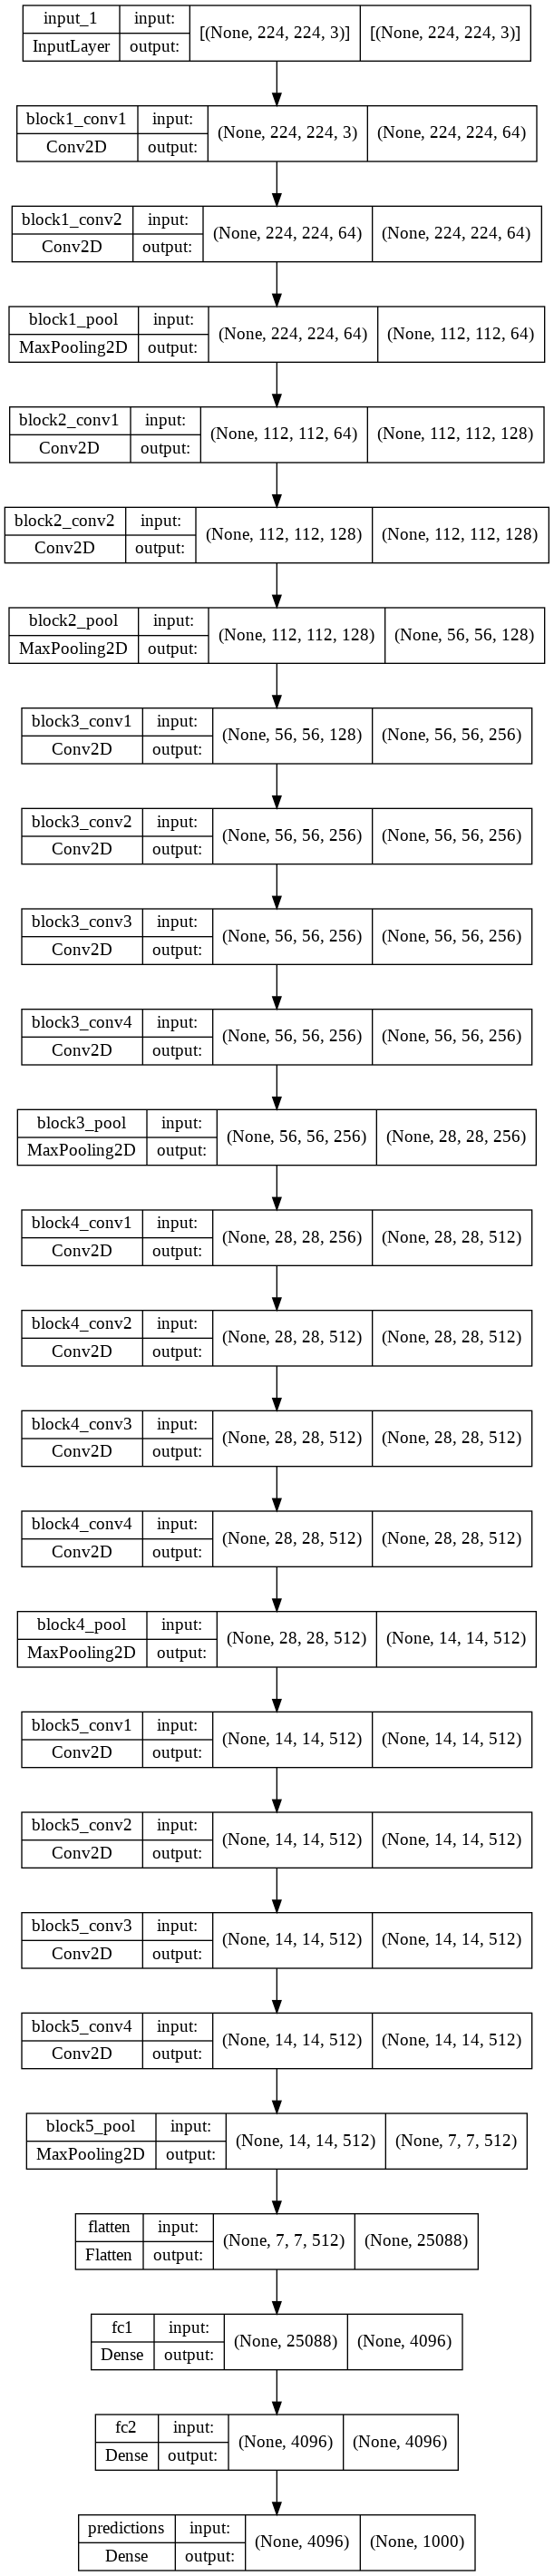

time: 217 ms (started: 2022-04-06 19:00:00 +00:00)


In [13]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [14]:
IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3 = model.input.shape[1:]
INPUT_SHAPE = (IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3)
IMAG_SIZE = (IMAGE_SIZE_1, IMAGE_SIZE_2)
print(INPUT_SHAPE, IMAG_SIZE)

(224, 224, 3) (224, 224)
time: 2.38 ms (started: 2022-04-06 19:00:01 +00:00)


---

# Caffe2RGB (undo imagenet_utils.preprocess_input)

In [15]:
# class to transform from caffe mode to RGB

class Caffe2RGB():

  def __init__(self, shape):
    'grab shape and compute baseline and topline'
    self.shape = shape
    self.compute_baseline()
    self.compute_topline()

  def compute_baseline(self):
    'baseline (all black) in caffe mode'
    self.baseline = imagenet_utils.preprocess_input(tf.zeros(shape=self.shape))

  def compute_topline(self):
    'topline (all white) in caffe mode'
    self.topline = imagenet_utils.preprocess_input(tf.ones(shape=self.shape) * 255)


  def convert(self, caffe_image):
    ' converts from caffe to RGB'
    image0 = (caffe_image - self.baseline).numpy() # shift caffe zero to actual zero
    image = image0[:,:,[2,1,0]] # BGR -> RGB
    return image


time: 9.93 ms (started: 2022-04-06 19:00:01 +00:00)


# **Compute autobaseline**

Ideally a good baseline should produce a uniform probability vector when fed to our model, i.e., all classes should have the same probability.

We acomplish this by chosing an initial baseline (a black image in this case) and then perturbing it using backpropagation with an appropropriate loss function with a term that reaches its minimum for uniform output.

Since we do not want the autobaseline to differ too much from the original baseline choosen, the loss function will include also a term penalizing the difference from the original baseline.

In [16]:
#initial baseline (= blank/black image)
baseline = tf.zeros(shape=INPUT_SHAPE)
baseline = imagenet_utils.preprocess_input(baseline) # default mode: caffe - to be used with imagenet images

time: 4.69 ms (started: 2022-04-06 19:00:01 +00:00)


In [17]:
for i in range(3):
  print(i,baseline.numpy()[:,:,i].min(),baseline.numpy()[:,:,i].mean(),baseline.numpy()[:,:,i].max())

0 -103.939 -103.93899 -103.939
1 -116.779 -116.77903 -116.779
2 -123.68 -123.68004 -123.68
time: 8.8 ms (started: 2022-04-06 19:00:01 +00:00)


In [18]:
# baseline network

num_of_units = IMAGE_SIZE_1 * IMAGE_SIZE_2 * IMAGE_SIZE_3

autobaseline_model = tf.keras.Sequential()
autobaseline_model.add(tf.keras.Input(shape=(1,), name='input'))
autobaseline_model.add(tf.keras.layers.Dense(num_of_units, use_bias=False, name='dense'))
autobaseline_model.add(tf.keras.layers.Reshape(INPUT_SHAPE, input_shape=(num_of_units,), name='reshape'))

autobaseline_model._name = 'autobaseline'

autobaseline_model.summary()

Model: "autobaseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150528)            150528    
                                                                 
 reshape (Reshape)           (None, 224, 224, 3)       0         
                                                                 
Total params: 150,528
Trainable params: 150,528
Non-trainable params: 0
_________________________________________________________________
time: 37.5 ms (started: 2022-04-06 19:00:01 +00:00)


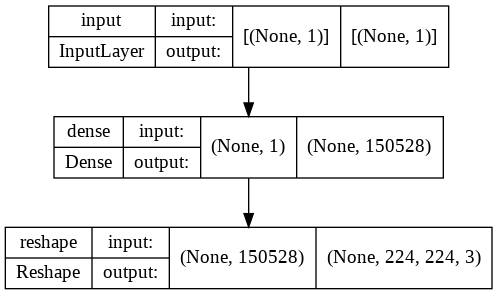

time: 90.6 ms (started: 2022-04-06 19:00:01 +00:00)


In [19]:
plot_model(autobaseline_model, to_file='autobaseline_model.png', show_shapes=True, show_layer_names=True)

In [20]:
# combined model = autobaseline model + VGG19

inp = tf.keras.layers.Input(shape=(1,))

base_out = autobaseline_model(inp) # this is the autobaseline output

model_out = model(base_out) # this is the VGG19 output

combined_model = tf.keras.models.Model(inputs = inp, outputs = [model_out, base_out]) # both outputs combined


time: 84.3 ms (started: 2022-04-06 19:00:01 +00:00)


In [21]:
combined_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 autobaseline (Sequential)   (None, 224, 224, 3)       150528    
                                                                 
 vgg19 (Functional)          (None, 1000)              143667240 
                                                                 
Total params: 143,817,768
Trainable params: 150,528
Non-trainable params: 143,667,240
_________________________________________________________________
time: 28.9 ms (started: 2022-04-06 19:00:01 +00:00)


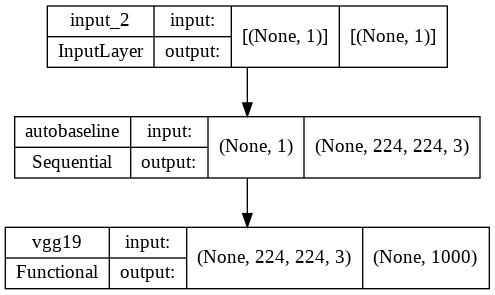

time: 105 ms (started: 2022-04-06 19:00:01 +00:00)


In [22]:
plot_model(combined_model, to_file='combined_model.png', show_shapes=True, show_layer_names=True)

In [23]:
# various ways to measure the difference between old and new baseline and network output

my_out = combined_model.predict([[1.0]]) # input is always 1.0
for o in my_out:
  print(o.shape)

print(my_out[0].min(),my_out[0].mean(),my_out[0].max()) # prob. vector
print(my_out[1].min(),my_out[1].mean(),my_out[1].max()) # computed baseline
print('-------------------------------------------------')
print(((my_out[0] - 1.0/my_out[0].size)**2).mean()) # prob. vector error
print((my_out[1]**2).mean()) # baseline output mean square
print((((my_out[1] - baseline.numpy()))**2).mean()) # baseline mse
print((((my_out[1] - baseline.numpy()))**2).mean()/(255.0)) #  weighted baseline mse 1
print((((my_out[1] - baseline.numpy()))**2).mean()/(255.0**2)) #  weighted baseline mse 2

(1, 1000)
(1, 224, 224, 3)
1.7286999e-05 0.001 0.04665094
-0.006313402 -7.646781e-07 0.006313427
-------------------------------------------------
5.139081e-06
1.3316469e-05
13245.797
51.944301470588236
0.20370314302191464
time: 2.79 s (started: 2022-04-06 19:00:01 +00:00)


In [24]:
# set initial weights equal to the elements of initial baseline
combined_model.get_layer('autobaseline').get_layer('dense').set_weights([np.expand_dims(baseline.numpy().flatten(), axis=0)])

time: 3.42 ms (started: 2022-04-06 19:00:04 +00:00)


In [25]:
# before training

my_out = combined_model.predict([[1.0]]) # input is always 1.0
for o in my_out:
  print(o.shape)

print(my_out[0].min(),my_out[0].mean(),my_out[0].max()) # prob. vector
print(my_out[1].min(),my_out[1].mean(),my_out[1].max()) # computed baseline
print('-------------------------------------------------')
print(((my_out[0] - 1.0/my_out[0].size)**2).mean()) # prob. vector error
print((my_out[1]**2).mean()) # baseline output mean square
print((((my_out[1] - baseline.numpy()))**2).mean()) # baseline mse
print((((my_out[1] - baseline.numpy()))**2).mean()/(255.0)) #  weighted baseline mse 1
print((((my_out[1] - baseline.numpy()))**2).mean()/(255.0**2)) #  weighted baseline mse 2

(1, 1000)
(1, 224, 224, 3)
1.743989e-05 0.001 0.07632058
-123.68 -114.79935 -103.939
-------------------------------------------------
1.2756569e-05
13245.796
0.0
0.0
0.0
time: 89.2 ms (started: 2022-04-06 19:00:04 +00:00)


In [26]:
# compile

learning_rate = 0.1
combined_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                       loss=[tf.keras.losses.CategoricalCrossentropy(), # to be applied to the probability vector output
                             tf.keras.losses.MeanSquaredError()], # to be applied to autobaseline vs initial baseline
                       loss_weights=[0.99,0.01])
pass

time: 16 ms (started: 2022-04-06 19:00:04 +00:00)


In [27]:
# before training

my_out = combined_model.predict([[1.0]]) # input is always 1.0
for o in my_out:
  print(o.shape)

print(my_out[0].min(),my_out[0].mean(),my_out[0].max()) # prob. vector
print(my_out[1].min(),my_out[1].mean(),my_out[1].max()) # computed baseline
print('-------------------------------------------------')
print(((my_out[0] - 1.0/my_out[0].size)**2).mean()) # prob. vector error
print((my_out[1]**2).mean()) # baseline output mean square
print((((my_out[1] - baseline.numpy()))**2).mean()) # baseline mse
print((((my_out[1] - baseline.numpy()))**2).mean()/(255.0)) #  weighted baseline mse 1
print((((my_out[1] - baseline.numpy()))**2).mean()/(255.0**2)) #  weighted baseline mse 2

(1, 1000)
(1, 224, 224, 3)
1.743989e-05 0.001 0.07632058
-123.68 -114.79935 -103.939
-------------------------------------------------
1.2756569e-05
13245.796
0.0
0.0
0.0
time: 274 ms (started: 2022-04-06 19:00:04 +00:00)


TRAIN THE COMBINED MODEL<br>
Input should be constant = 1.0, output is a 1000 element probability vector and a 224 x 224 x 3 (image) tensor.<br>
Goal is to make output close to uniform probability vector and output image close to initial baseline.

In [28]:
x_train = np.array([1.0] * 32)
y_train0 = np.array([[1.0/1000] * 1000 ] * 32)
y_train1 = np.array([baseline] * 32)

x_test = x_train
y_test0 = y_train0
y_test1 = y_train1

print(x_train.shape, y_train0.shape, y_train1.shape, x_test.shape, y_test0.shape, y_test1.shape)

(32,) (32, 1000) (32, 224, 224, 3) (32,) (32, 1000) (32, 224, 224, 3)
time: 16.1 ms (started: 2022-04-06 19:00:04 +00:00)


In [29]:
EPOCHS = 200
BATCH_SIZE = 64

history = combined_model.fit(x_train, [y_train0, y_train1], epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(x_test, [y_test0, y_test1]) )

Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 7.7751 - vgg19_loss: 7.8536 - autobaseline_loss: 0.0000e+00 - val_loss: 7.7630 - val_vgg19_loss: 7.8410 - val_autobaseline_loss: 0.0414
Epoch 2/200
1/1 [==============================] - 1s 538ms/step - loss: 7.7630 - vgg19_loss: 7.8410 - autobaseline_loss: 0.0414 - val_loss: 7.6573 - val_vgg19_loss: 7.7337 - val_autobaseline_loss: 0.1018
Epoch 3/200
1/1 [==============================] - 1s 539ms/step - loss: 7.6573 - vgg19_loss: 7.7337 - autobaseline_loss: 0.1018 - val_loss: 7.5664 - val_vgg19_loss: 7.6411 - val_autobaseline_loss: 0.1734
Epoch 4/200
1/1 [==============================] - 1s 534ms/step - loss: 7.5664 - vgg19_loss: 7.6411 - autobaseline_loss: 0.1734 - val_loss: 7.4654 - val_vgg19_loss: 7.5384 - val_autobaseline_loss: 0.2333
Epoch 5/200
1/1 [==============================] - 1s 539ms/step - loss: 7.4654 - vgg19_loss: 7.5384 - autobaseline_loss: 0.2333 - val_loss: 7.3558 - val_vgg19_loss: 7.4274 - val_

In [30]:
# after training

my_out = combined_model.predict([[1.0]]) # input is always 1.0
for o in my_out:
  print(o.shape)

print(my_out[0].min(),my_out[0].mean(),my_out[0].max()) # prob. vector
print(my_out[1].min(),my_out[1].mean(),my_out[1].max()) # computed baseline
print('-----------------------------------------------------------')
print(((my_out[0] - 1.0/my_out[0].size)**2).mean()) # prob. vector error
print((my_out[1]**2).mean()) # baseline output mean square
print((((my_out[1] - baseline.numpy()))**2).mean()) # baseline mse
print((((my_out[1] - baseline.numpy()))**2).mean()/(255.0)) #  weighted baseline mse 1
print((((my_out[1] - baseline.numpy()))**2).mean()/(255.0**2)) #  weighted baseline mse 2

(1, 1000)
(1, 224, 224, 3)
0.00046712972 0.001 0.0021348118
-132.273 -114.791084 -94.64418
-----------------------------------------------------------
6.233243e-08
13245.334
1.339005
0.005250999974269493
2.059215676184115e-05
time: 229 ms (started: 2022-04-06 19:02:01 +00:00)


In [31]:
caffe2rgb_out = Caffe2RGB(my_out[1][0].shape)
baseline_out = caffe2rgb_out.convert(my_out[1][0])

time: 6.04 ms (started: 2022-04-06 19:02:01 +00:00)


In [32]:
print(baseline_out.min(),baseline_out.mean(),baseline_out.max())

-8.592995 0.008254691 9.294823
time: 1.4 ms (started: 2022-04-06 19:02:01 +00:00)


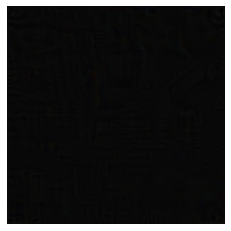

time: 78.5 ms (started: 2022-04-06 19:02:01 +00:00)


In [33]:
# Visualizing the autobaseline obtained after training
# (barely visible)

plt.imshow((baseline_out - baseline_out.min())/ 255.0)
plt.axis('off')
pass

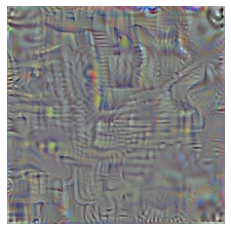

time: 90.2 ms (started: 2022-04-06 19:02:01 +00:00)


In [34]:
# Normalized autobaseline

plt.imshow((baseline_out - baseline_out.min())/(baseline_out.max() - baseline_out.min()))
plt.axis('off')
pass

In [35]:
# select autobaseline to be used in next section
autobaseline = my_out[1][0]

time: 929 µs (started: 2022-04-06 19:02:02 +00:00)


In [36]:
# uncomment if you want to save the autobaseline
'''
# save autobaseline

with open(root + 'autobaseline.pickle', "wb") as f:
  pickle.dump(autobaseline,f)
'''
pass

time: 748 µs (started: 2022-04-06 19:02:02 +00:00)


In [37]:
# this is to load a previously saved autobaseline
'''
# load autobaseline

with open(root + 'autobaseline.pickle', "rb") as f:
  autobaseline_load = pickle.load(f)
'''
pass

time: 961 µs (started: 2022-04-06 19:02:02 +00:00)


---

In [38]:
# produce two lists of instances of the attribution method, one using the original baseline, the other one using autobaseline

layer_names = ['input_1', 'block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']

rsi_gradcam_list = [RSI_GradCAM(model, layerName=layerName, baseline=baseline) for layerName in layer_names]
auto_rsi_gradcam_list = [RSI_GradCAM(model, layerName=layerName, baseline=autobaseline) for layerName in layer_names]

time: 34.2 ms (started: 2022-04-06 19:02:02 +00:00)


---

# Heatmap displays

In [39]:
# Function to display heatmaps of an image obtained at different layers of the model

def display_heatmaps(orig_image,layerNo,top_pred=0):

    layerName = layer_names[layerNo]

    print('layerName =',layerName)
    print()

    orig_bgr = cv2.imread(orig_image) # cv2 loads in BGR format!
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB) # transform to RGB

    #resized = cv2.resize(orig_bgr, (224, 224))

    # load the input image from disk (in Keras/TensorFlow format) and
    # preprocess it
    image = load_img(orig_image, target_size=(IMAGE_SIZE_1, IMAGE_SIZE_2)) # RGB
    image = img_to_array(image)

    #image = img_to_array(resized)

    image = np.expand_dims(image, axis=0)

    image = imagenet_utils.preprocess_input(image) # default mode: caffe
    # caffe: will convert the images from RGB to BGR, 
    # then will zero-center each color channel with respect 
    # to the ImageNet dataset, without scaling.

    print(image.shape)
    print(image[:,:,0].min(), image[:,:,0].mean(), image[:,:,0].max())
    print(image[:,:,1].min(), image[:,:,1].mean(), image[:,:,1].max())
    print(image[:,:,2].min(), image[:,:,2].mean(), image[:,:,2].max())
    print()

    # use the network to make predictions on the input imag and find
    # the class label index with the largest corresponding probability
    preds = model.predict(image)
    #i = np.argmax(preds[0]) # TODO: how do you pick a different class from the first one predicted???
    
    i = np.argsort(preds[0])[-1-top_pred]

    # decode the ImageNet predictions to obtain the human-readable label
    decoded = imagenet_utils.decode_predictions(preds, top=30)
    for j in range(len(decoded[0])):
        print(j, decoded[0][j])
    #(imagenetID, label, prob) = decoded[0][0]
    (imagenetID, label, prob) = decoded[0][top_pred]
    label = "{}: {:.4f}%".format(label, prob * 100)
    print('image index =', i)
    print()
    print("[INFO] {}".format(label))

    # get the various versions of rsi-gradcam
    rsi_gradcam = rsi_gradcam_list[layerNo]
    auto_rsi_gradcam = auto_rsi_gradcam_list[layerNo]

    # produce heatmaps
    _, heatmap_rsi_gradcam = rsi_gradcam.compute_heatmap(image,i)
    _, heatmap_auto_rsi_gradcam = auto_rsi_gradcam.compute_heatmap(image,i)

    # resize the resulting heatmaps to the original input image dimensions
    # and then overlay heatmap on top of the image

    heatmap_rsi_gradcam = cv2.resize(heatmap_rsi_gradcam, (orig_rgb.shape[1], orig_rgb.shape[0]))
    (heatmap_rsi_gradcam, output_rsi_gradcam) = overlay_heatmap(heatmap_rsi_gradcam, orig_rgb, alpha=0.5)

    heatmap_auto_rsi_gradcam = cv2.resize(heatmap_auto_rsi_gradcam, (orig_rgb.shape[1], orig_rgb.shape[0]))
    (heatmap_auto_rsi_gradcam, output_auto_rsi_gradcam) = overlay_heatmap(heatmap_auto_rsi_gradcam, orig_rgb, alpha=0.5)


    # display the original image and resulting heatmap and output image
    # to our screen

    output_rsi_gradcam = np.vstack([orig_rgb, heatmap_rsi_gradcam, output_rsi_gradcam])
    output_rsi_gradcam = imutils.resize(output_rsi_gradcam, height=700)

    output_auto_rsi_gradcam = np.vstack([orig_rgb, heatmap_auto_rsi_gradcam, output_auto_rsi_gradcam])
    output_auto_rsi_gradcam = imutils.resize(output_auto_rsi_gradcam, height=700)


    plt.rcParams.update({'font.size':15})
    plt.figure(figsize=(10,10))
    
    ax = plt.subplot(1,2,1)
    plt.imshow(output_rsi_gradcam)
    plt.title('RSI-Grad-CAM\n{}'.format(layerName))
    plt.axis('off')

    ax = plt.subplot(1,2,2)
    plt.imshow(output_auto_rsi_gradcam)
    plt.title('Auto RSI-Grad-CAM\n{}'.format(layerName))
    plt.axis('off')

pass

time: 91.5 ms (started: 2022-04-06 19:02:02 +00:00)


In [40]:
orig_image = images_dir + 'pick.jpg'

time: 637 µs (started: 2022-04-06 19:02:02 +00:00)


layerName = block5_pool

(1, 224, 224, 3)
-123.68 -114.05083 -92.939
-123.68 -114.608864 -99.939
-123.68 -113.890114 -93.939

0 ('n03929660', 'pick', 1.0)
1 ('n04116512', 'rubber_eraser', 1.875385e-09)
2 ('n03291819', 'envelope', 4.942063e-10)
3 ('n03814906', 'necklace', 5.138606e-11)
4 ('n02840245', 'binder', 2.4781701e-11)
5 ('n03642806', 'laptop', 1.7187503e-11)
6 ('n04447861', 'toilet_seat', 1.5717724e-11)
7 ('n03666591', 'lighter', 1.2278155e-11)
8 ('n02786058', 'Band_Aid', 1.118777e-11)
9 ('n03724870', 'mask', 1.117555e-11)
10 ('n04270147', 'spatula', 1.0745126e-11)
11 ('n01496331', 'electric_ray', 9.324369e-12)
12 ('n04192698', 'shield', 9.161669e-12)
13 ('n03271574', 'electric_fan', 9.059372e-12)
14 ('n04074963', 'remote_control', 7.993542e-12)
15 ('n07248320', 'book_jacket', 7.955394e-12)
16 ('n03873416', 'paddle', 6.6891293e-12)
17 ('n02807133', 'bathing_cap', 6.5903745e-12)
18 ('n03775071', 'mitten', 6.2463216e-12)
19 ('n03871628', 'packet', 5.7566534e-12)
20 ('n03250847', '

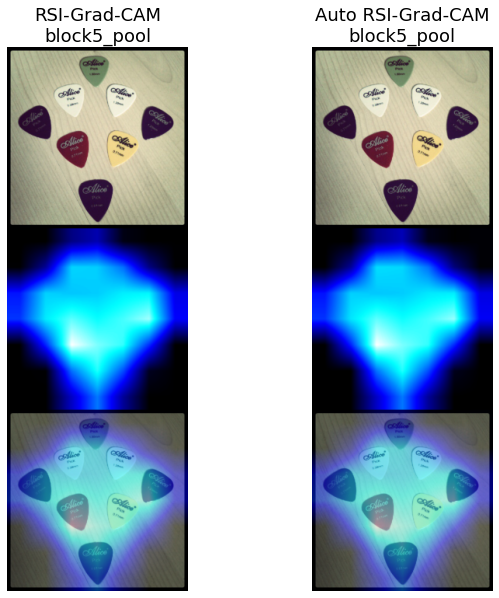

time: 9.51 s (started: 2022-04-06 19:02:02 +00:00)


In [41]:
display_heatmaps(orig_image,-1)

layerName = block4_pool

(1, 224, 224, 3)
-123.68 -114.05083 -92.939
-123.68 -114.608864 -99.939
-123.68 -113.890114 -93.939

0 ('n03929660', 'pick', 1.0)
1 ('n04116512', 'rubber_eraser', 1.875385e-09)
2 ('n03291819', 'envelope', 4.942063e-10)
3 ('n03814906', 'necklace', 5.138606e-11)
4 ('n02840245', 'binder', 2.4781701e-11)
5 ('n03642806', 'laptop', 1.7187503e-11)
6 ('n04447861', 'toilet_seat', 1.5717724e-11)
7 ('n03666591', 'lighter', 1.2278155e-11)
8 ('n02786058', 'Band_Aid', 1.118777e-11)
9 ('n03724870', 'mask', 1.117555e-11)
10 ('n04270147', 'spatula', 1.0745126e-11)
11 ('n01496331', 'electric_ray', 9.324369e-12)
12 ('n04192698', 'shield', 9.161669e-12)
13 ('n03271574', 'electric_fan', 9.059372e-12)
14 ('n04074963', 'remote_control', 7.993542e-12)
15 ('n07248320', 'book_jacket', 7.955394e-12)
16 ('n03873416', 'paddle', 6.6891293e-12)
17 ('n02807133', 'bathing_cap', 6.5903745e-12)
18 ('n03775071', 'mitten', 6.2463216e-12)
19 ('n03871628', 'packet', 5.7566534e-12)
20 ('n03250847', '

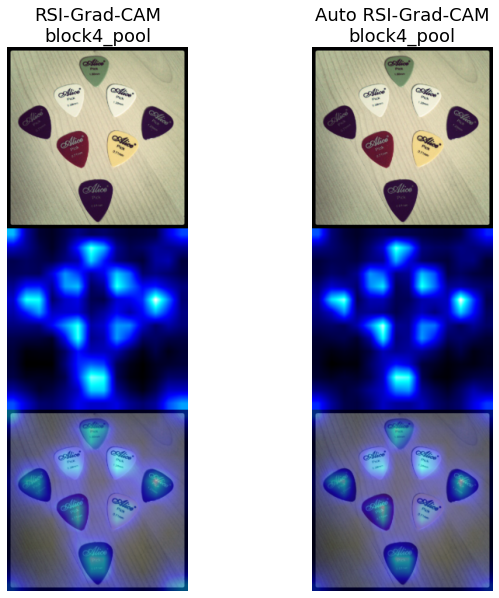

time: 2.69 s (started: 2022-04-06 19:02:11 +00:00)


In [42]:
display_heatmaps(orig_image,-2)

layerName = block3_pool

(1, 224, 224, 3)
-123.68 -114.05083 -92.939
-123.68 -114.608864 -99.939
-123.68 -113.890114 -93.939

0 ('n03929660', 'pick', 1.0)
1 ('n04116512', 'rubber_eraser', 1.875385e-09)
2 ('n03291819', 'envelope', 4.942063e-10)
3 ('n03814906', 'necklace', 5.138606e-11)
4 ('n02840245', 'binder', 2.4781701e-11)
5 ('n03642806', 'laptop', 1.7187503e-11)
6 ('n04447861', 'toilet_seat', 1.5717724e-11)
7 ('n03666591', 'lighter', 1.2278155e-11)
8 ('n02786058', 'Band_Aid', 1.118777e-11)
9 ('n03724870', 'mask', 1.117555e-11)
10 ('n04270147', 'spatula', 1.0745126e-11)
11 ('n01496331', 'electric_ray', 9.324369e-12)
12 ('n04192698', 'shield', 9.161669e-12)
13 ('n03271574', 'electric_fan', 9.059372e-12)
14 ('n04074963', 'remote_control', 7.993542e-12)
15 ('n07248320', 'book_jacket', 7.955394e-12)
16 ('n03873416', 'paddle', 6.6891293e-12)
17 ('n02807133', 'bathing_cap', 6.5903745e-12)
18 ('n03775071', 'mitten', 6.2463216e-12)
19 ('n03871628', 'packet', 5.7566534e-12)
20 ('n03250847', '

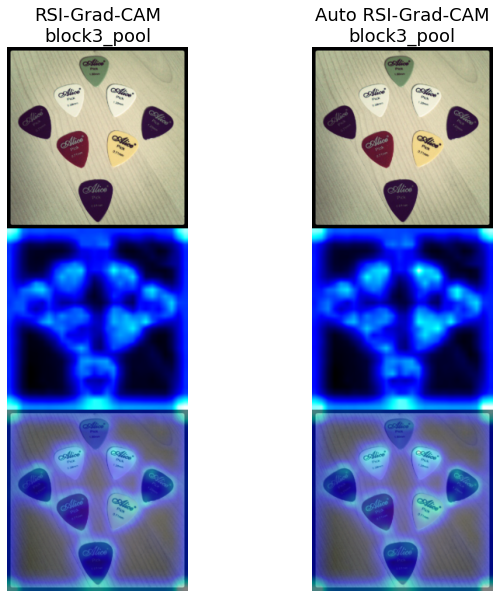

time: 2.7 s (started: 2022-04-06 19:02:14 +00:00)


In [43]:
display_heatmaps(orig_image,-3)

In [44]:
orig_image = images_dir + 'yellow_ladys_slipper.jpg'

time: 1.02 ms (started: 2022-04-06 19:02:17 +00:00)


layerName = block5_pool

(1, 224, 224, 3)
-122.68 -89.83208 -2.7789993
-122.68 -89.601425 -1.7789993
-122.68 -89.7041 0.22100067

0 ('n12057211', "yellow_lady's_slipper", 1.0)
1 ('n07749582', 'lemon', 4.5098866e-10)
2 ('n01531178', 'goldfinch', 2.801998e-11)
3 ('n02281406', 'sulphur_butterfly', 2.6999025e-11)
4 ('n07716358', 'zucchini', 1.0595197e-11)
5 ('n07720875', 'bell_pepper', 4.532432e-12)
6 ('n01945685', 'slug', 3.040587e-12)
7 ('n01739381', 'vine_snake', 2.1894513e-12)
8 ('n07716906', 'spaghetti_squash', 8.738337e-13)
9 ('n01729977', 'green_snake', 8.116073e-13)
10 ('n02219486', 'ant', 7.5670606e-13)
11 ('n02206856', 'bee', 7.314382e-13)
12 ('n01644373', 'tree_frog', 5.5843915e-13)
13 ('n07718472', 'cucumber', 5.4042225e-13)
14 ('n12620546', 'hip', 5.279658e-13)
15 ('n13133613', 'ear', 3.4563018e-13)
16 ('n07717556', 'butternut_squash', 3.2227769e-13)
17 ('n07753113', 'fig', 3.19287e-13)
18 ('n12768682', 'buckeye', 2.9444185e-13)
19 ('n07747607', 'orange', 2.1052164e-13)
20 ('n

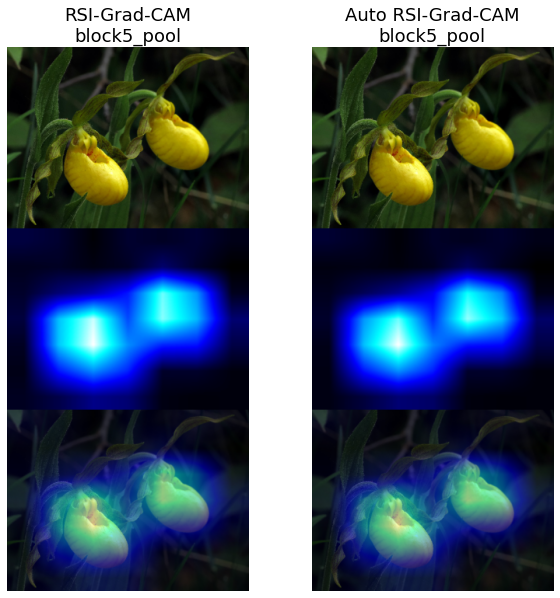

time: 2.7 s (started: 2022-04-06 19:02:17 +00:00)


In [45]:
display_heatmaps(orig_image,-1)

layerName = block4_pool

(1, 224, 224, 3)
-122.68 -89.83208 -2.7789993
-122.68 -89.601425 -1.7789993
-122.68 -89.7041 0.22100067

0 ('n12057211', "yellow_lady's_slipper", 1.0)
1 ('n07749582', 'lemon', 4.5098866e-10)
2 ('n01531178', 'goldfinch', 2.801998e-11)
3 ('n02281406', 'sulphur_butterfly', 2.6999025e-11)
4 ('n07716358', 'zucchini', 1.0595197e-11)
5 ('n07720875', 'bell_pepper', 4.532432e-12)
6 ('n01945685', 'slug', 3.040587e-12)
7 ('n01739381', 'vine_snake', 2.1894513e-12)
8 ('n07716906', 'spaghetti_squash', 8.738337e-13)
9 ('n01729977', 'green_snake', 8.116073e-13)
10 ('n02219486', 'ant', 7.5670606e-13)
11 ('n02206856', 'bee', 7.314382e-13)
12 ('n01644373', 'tree_frog', 5.5843915e-13)
13 ('n07718472', 'cucumber', 5.4042225e-13)
14 ('n12620546', 'hip', 5.279658e-13)
15 ('n13133613', 'ear', 3.4563018e-13)
16 ('n07717556', 'butternut_squash', 3.2227769e-13)
17 ('n07753113', 'fig', 3.19287e-13)
18 ('n12768682', 'buckeye', 2.9444185e-13)
19 ('n07747607', 'orange', 2.1052164e-13)
20 ('n

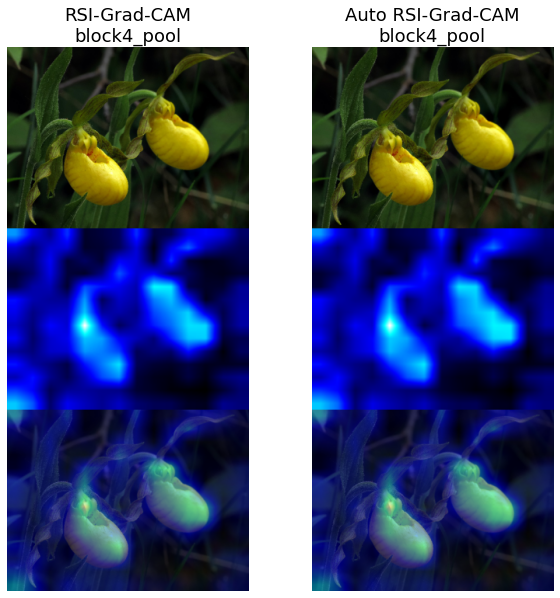

time: 2.72 s (started: 2022-04-06 19:02:19 +00:00)


In [46]:
display_heatmaps(orig_image,-2)

layerName = block3_pool

(1, 224, 224, 3)
-122.68 -89.83208 -2.7789993
-122.68 -89.601425 -1.7789993
-122.68 -89.7041 0.22100067

0 ('n12057211', "yellow_lady's_slipper", 1.0)
1 ('n07749582', 'lemon', 4.5098866e-10)
2 ('n01531178', 'goldfinch', 2.801998e-11)
3 ('n02281406', 'sulphur_butterfly', 2.6999025e-11)
4 ('n07716358', 'zucchini', 1.0595197e-11)
5 ('n07720875', 'bell_pepper', 4.532432e-12)
6 ('n01945685', 'slug', 3.040587e-12)
7 ('n01739381', 'vine_snake', 2.1894513e-12)
8 ('n07716906', 'spaghetti_squash', 8.738337e-13)
9 ('n01729977', 'green_snake', 8.116073e-13)
10 ('n02219486', 'ant', 7.5670606e-13)
11 ('n02206856', 'bee', 7.314382e-13)
12 ('n01644373', 'tree_frog', 5.5843915e-13)
13 ('n07718472', 'cucumber', 5.4042225e-13)
14 ('n12620546', 'hip', 5.279658e-13)
15 ('n13133613', 'ear', 3.4563018e-13)
16 ('n07717556', 'butternut_squash', 3.2227769e-13)
17 ('n07753113', 'fig', 3.19287e-13)
18 ('n12768682', 'buckeye', 2.9444185e-13)
19 ('n07747607', 'orange', 2.1052164e-13)
20 ('n

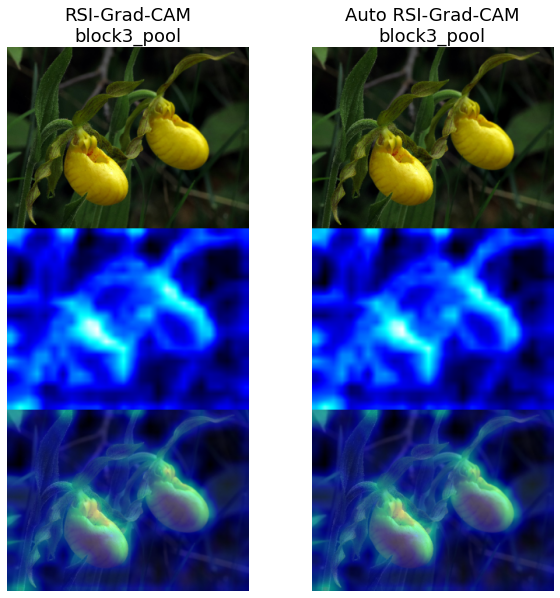

time: 2.73 s (started: 2022-04-06 19:02:22 +00:00)


In [47]:
display_heatmaps(orig_image,-3)